In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
#!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37)

In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

# **Preprocessing**

## **LabelEncoder**

In [5]:
cols = ['LINE', 'PRODUCT_CODE']

for i in cols:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

## **drop**

In [6]:
cols = ['PRODUCT_ID', 'TIMESTAMP']
for col in cols:
    train.drop([col], axis=1, inplace=True)
    test.drop([col], axis=1, inplace=True)

cols = ['X_934', 'X_935', 'X_936', 'X_937', 'X_2628', 'X_2629', 'X_2630',
        'X_2631', 'X_2632', 'X_2633', 'X_2634', 'X_2635', 'X_2636', 'X_2637',
        'X_2638', 'X_2639', 'X_2640', 'X_2641', 'X_2642', 'X_2643', 'X_2644',
        'X_2645', 'X_2646', 'X_2647', 'X_2648', 'X_2649', 'X_2650', 'X_2651',
        'X_2652', 'X_2653', 'X_2654', 'X_2655', 'X_2656', 'X_2657', 'X_2658',
        'X_2659', 'X_2660', 'X_2661', 'X_2662', 'X_2663', 'X_2664', 'X_2665',
        'X_2666', 'X_2667', 'X_2668', 'X_2669', 'X_2670', 'X_2671', 'X_2672',
        'X_2673', 'X_2674', 'X_2675', 'X_2676', 'X_2677', 'X_2678', 'X_2679',
        'X_2680', 'X_2681', 'X_2682', 'X_2683', 'X_2684', 'X_2685', 'X_2686',
        'X_2687', 'X_2688', 'X_2689', 'X_2690', 'X_2691', 'X_2692', 'X_2693',
        'X_2694', 'X_2695', 'X_2696', 'X_2697', 'X_2698', 'X_2699', 'X_2838',
        'X_2844', 'X_2872', 'X_2873', 'X_2874', 'X_2875']
for col in cols:
    train.drop([col], axis=1, inplace=True)
    test.drop([col], axis=1, inplace=True)

## **fillna**

In [7]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [8]:
print('train shape :', train.shape, '\ntest shape :', test.shape)

train shape : (598, 2879) 
test shape : (310, 2877)


# **Model**

## **Parameters**

[**Model Parameters**](https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#model-parameters)

**n_d**
- [8, 64], 8
- Width of the decision prediction layer
- 값이 클수록 과적합 위험 모델에 많은 capacity를 제공함

**n_a** 
- 8
- Width of the attention embedding for each mask
- n_d=n_a 가 good choice

**n_steps**
- [3, 10], 3
- Number of steps in the architecture

**gamma**
- [1.0, 2.0], 1.3
- the coefficient for feature reusage in the masks
- 1에 가까울수록 레이어 간 상관관계가 적음

**n_independent**
- [1, 5], 2
- Number of independent Gated Linear Units layers at each step

**n_shared**
- [1, 5], 2

**epsilon** 
- 1e-15
- Should be left untouched

**seed** : 37,

**momentum** 
- [0.01, 0.4], 0.02
- for batch normalization

**clip_value** 
- None
- If a float is given this will clip the gradient

**lambda_sparse**
- 1e-3
- the extra sparsity loss coefficient
- 값이 클수록 feature selection 측면에서 model이 sparser 됨

**optimizer_fn**
- torch.optim.Adam
- Pytorch optimizer function

**optimizer_params**
- dict(lr=2e-2)
- optimizer_fn과 호환되는 파라미터로, optimizer를 초기화 함
- 기본 optimizer인 Adam으로, training에 사용되는 initial learning rate를 정의함

**scheduler_fn**
- None
- training 중 learning rate를 변경함

**scheduler_params**
- None
- Dictionnary of parameters to apply to the scheduler_fn

**model_name**
- 'DreamQuarkTabNet'
- Name of the model used for saving in disk
- 훈련된 모델을 쉽게 검색하고 재사용 할 수 있음

**verbose**
- 1
- every epoch : 1, None : 0  

**device_name**
- 'auto'
- 'cpu' for cpu training,'gpu' for gpu training,'auto' to automatically detect gpu

**mask_type**
- 'sparsemax'
- 'sparsemax' or 'entmax'
- the masking function to use for selecting features  

**n_shared_decoder**
- 1
- Number of shared GLU block in decoder
- only useful for TabNetPretrainer

**n_indep_decoder** 
- 1
- Number of independent GLU block in decoder
- only useful for TabNetPretrainer

**[Fit Parameters](https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#fit-parameters)**

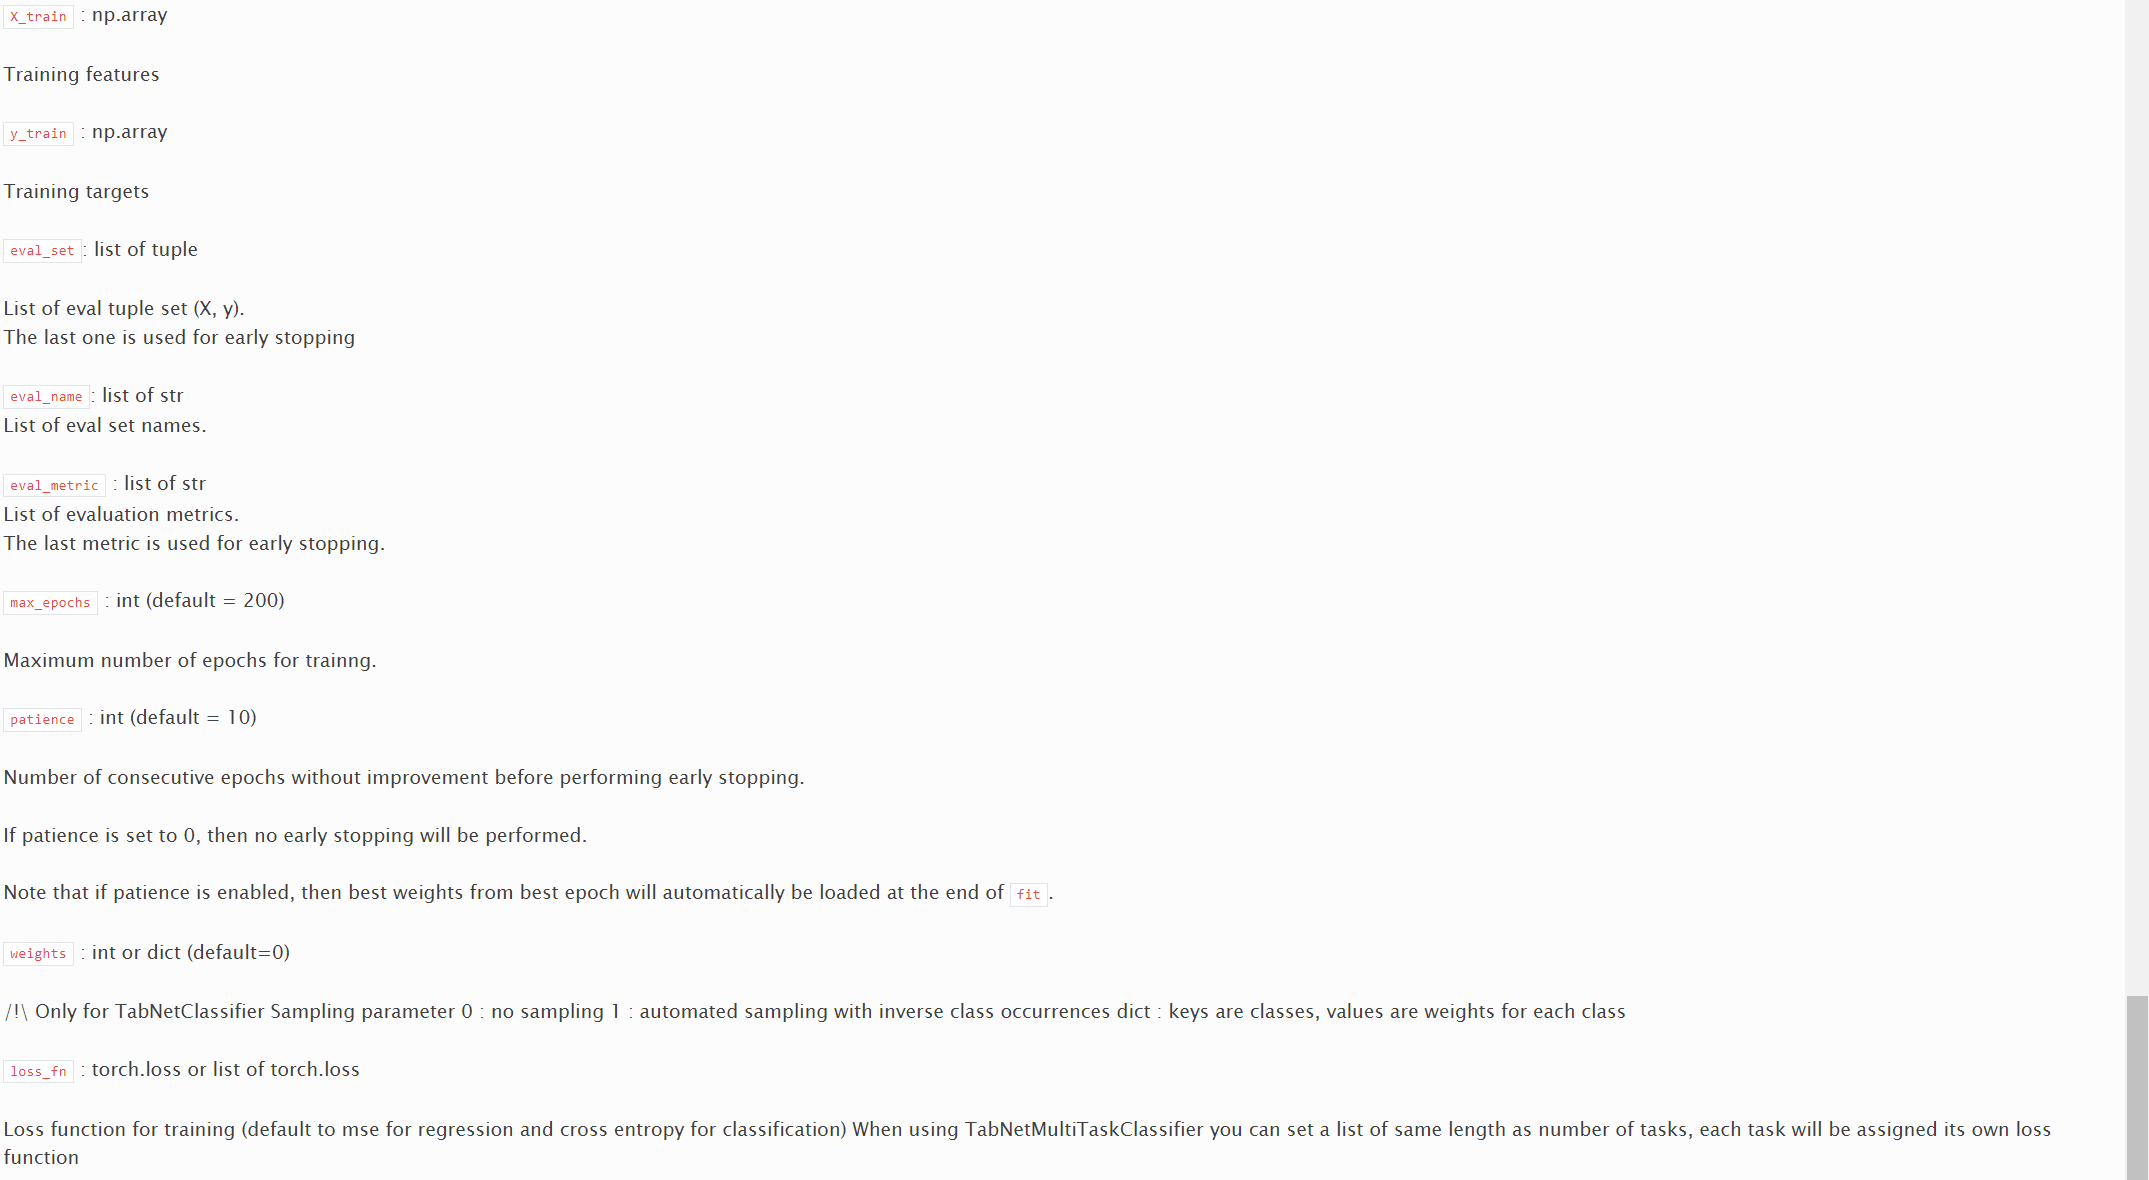

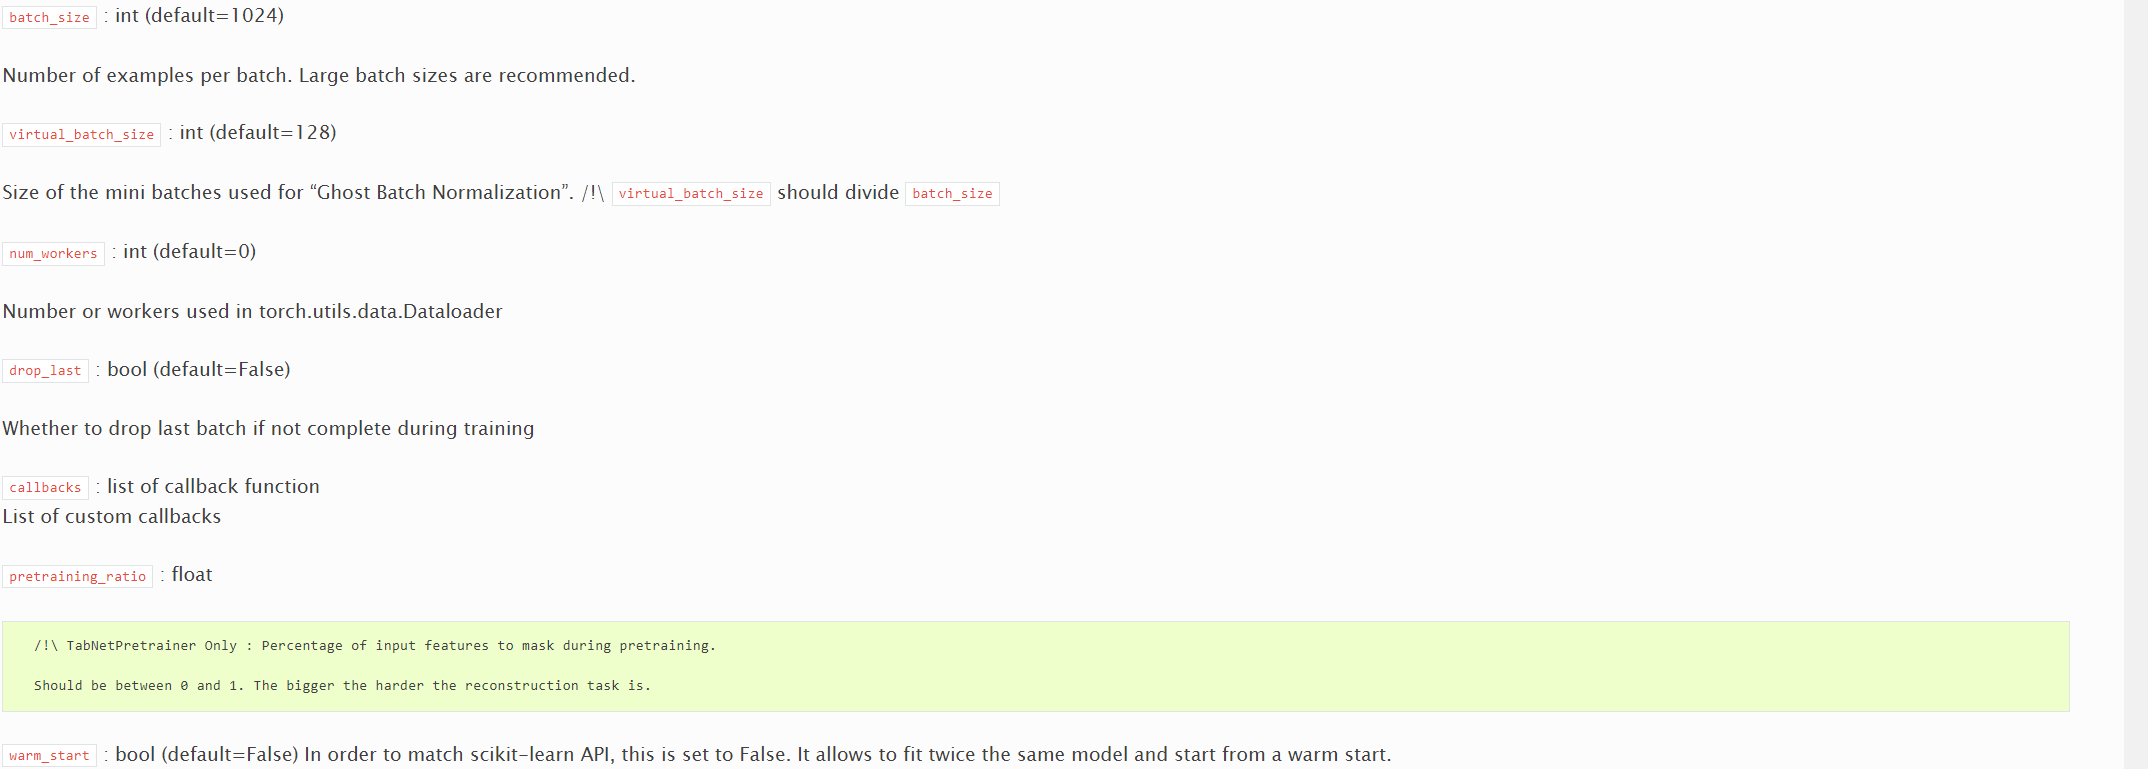

## **split**

In [9]:
X = train.drop(columns=['Y_Class', 'Y_Quality']) # data
y = train['Y_Class']                             # target

X_tst = test

In [10]:
X_trn, X_val, y_trn, y_val = train_test_split(
    X, y, 
    test_size=0.07,
    stratify=y
)

In [11]:
print('X_trn (data) :', X_trn.shape, '\ny_trn (target) :', y_trn.shape, 
      '\nX_val (data) :', X_val.shape, '\ny_val (target) :', y_val.shape)

X_trn (data) : (556, 2877) 
y_trn (target) : (556,) 
X_val (data) : (42, 2877) 
y_val (target) : (42,)


## **[TabNetClassifier](https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#how-to-use-it)**

**TabNetPretrainer**

unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # 'sparsemax' 'entmax'
)

unsupervised_model.fit(
    X_train = np.array(X_trn.values),
    eval_set = [np.array(X_val.values)],
    patience=100,
    max_epochs=80,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.9
)

(n_d: int = 8, n_a: int = 8, n_steps: int = 3, gamma: float = 1.3, cat_idxs: List[int] = list, cat_dims: List[int] = list, cat_emb_dim: int = 1, n_independent: int = 2, n_shared: int = 2, epsilon: float = 1e-15, momentum: float = 0.02, lambda_sparse: float = 0.001, seed: int = 0, clip_value: int = 1, verbose: int = 1, optimizer_fn: Any = torch.optim.Adam, optimizer_params: Dict = lambda : dict(lr=0.02), scheduler_fn: Any = None, scheduler_params: Dict = dict, mask_type: str = "sparsemax", input_dim: int = None, output_dim: int = None, device_name: str = "auto", n_shared_decoder: int = 1, n_indep_decoder: int = 1) -> None

In [12]:
clf = TabNetClassifier(
    n_d=100, # 64 100
    n_a=100,
    n_steps=5,
    gamma=1.3,
    n_independent=3,
    n_shared=3,
    epsilon=1e-15,
    momentum=2e-2,
    clip_value=1,
    lambda_sparse=1e-3,
    verbose=1,
    
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',

    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau, # https://keras.io/api/callbacks/reduce_lr_on_plateau/
    scheduler_params=dict(                                  
        mode='min', # 'min' 'max'  
        patience=10,
        min_lr=2e-2,
        factor=0.6,
        verbose=True
    ),
    input_dim=None,
    output_dim=None
)

clf.fit(
    X_train=np.array(X_trn.values), 
    y_train=np.array(y_trn.values),
    eval_set=[(np.array(X_trn.values), np.array(y_trn.values)), 
              (np.array(X_val.values), np.array(y_val.values))],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=1000,     
    patience=10,
    batch_size=16384, # 2^10
    virtual_batch_size=2048, # 2^7
    num_workers=0,
    drop_last=False,
    warm_start=False
)

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.25998 | train_logloss: 23.48785| valid_logloss: 23.84926|  0:00:00s
epoch 1  | loss: 1.51772 | train_logloss: 24.77206| valid_logloss: 27.50923|  0:00:00s
epoch 2  | loss: 1.66384 | train_logloss: 22.29987| valid_logloss: 21.38848|  0:00:01s
epoch 3  | loss: 1.50209 | train_logloss: 19.63434| valid_logloss: 16.50742|  0:00:01s
epoch 4  | loss: 1.56078 | train_logloss: 11.83838| valid_logloss: 11.53284|  0:00:01s
epoch 5  | loss: 1.40498 | train_logloss: 10.36428| valid_logloss: 12.86287|  0:00:01s
epoch 6  | loss: 1.22543 | train_logloss: 10.2498 | valid_logloss: 12.89872|  0:00:01s
epoch 7  | loss: 1.41125 | train_logloss: 10.65839| valid_logloss: 12.15096|  0:00:01s
epoch 8  | loss: 1.39726 | train_logloss: 6.89648 | valid_logloss: 9.98117 |  0:00:01s
epoch 9  | loss: 1.25193 | train_logloss: 5.31501 | valid_logloss: 6.01617 |  0:00:02s
epoch 10 | loss: 1.43074 | train_logloss: 4.96107 | valid_logloss: 6.97429 |  0:00:02s
epoch 11 | loss: 1.34499 | train_logloss: 6

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# **Result**

In [13]:
preds = clf.predict(np.array(X_tst.values))

sample_submission['Y_Class'] = preds
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/tabnet_4.csv', index=False)

result = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabnet_4.csv')
result.Y_Class.value_counts()

1    272
0     37
2      1
Name: Y_Class, dtype: int64